# BA Autocorrelation
$\tau_S=1.0,\,\epsilon=0.2$
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 10/27/2021|

## Python Imports

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import fft
from scipy.optimize import curve_fit

# Saturation Morphology

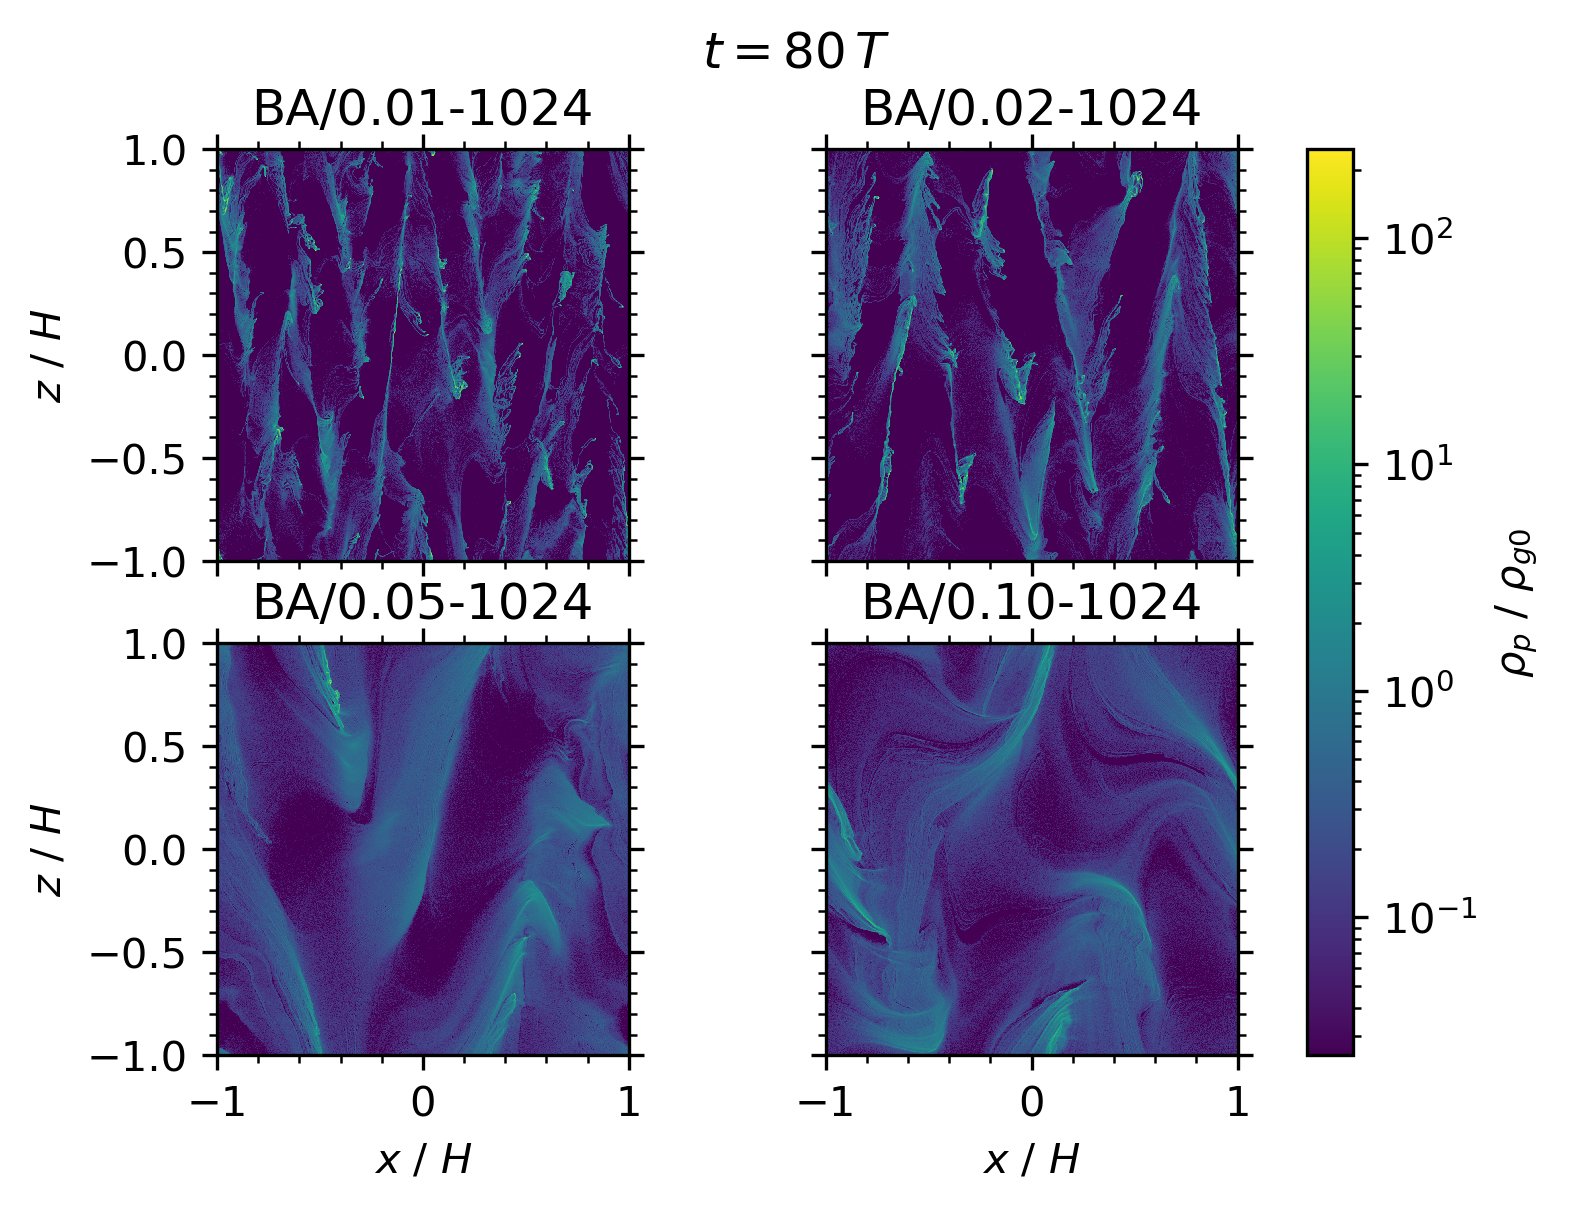

In [13]:
fig, axs = plt.subplots(2, 2, dpi=300)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
vmax, vmag = 0, 1e4

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%runs[i]\
                             +athinput["job"]["problem_id"]+'.out2.02000.athdf')
    if np.amax(data['rhop'][0]) > vmax:
        vmax = np.amax(data['rhop'][0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clip = np.clip(data['rhop'][0], vmax/vmag, vmax)
    
    # Plot
    img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
    ax.set(title=r'{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

# Autocorrelation

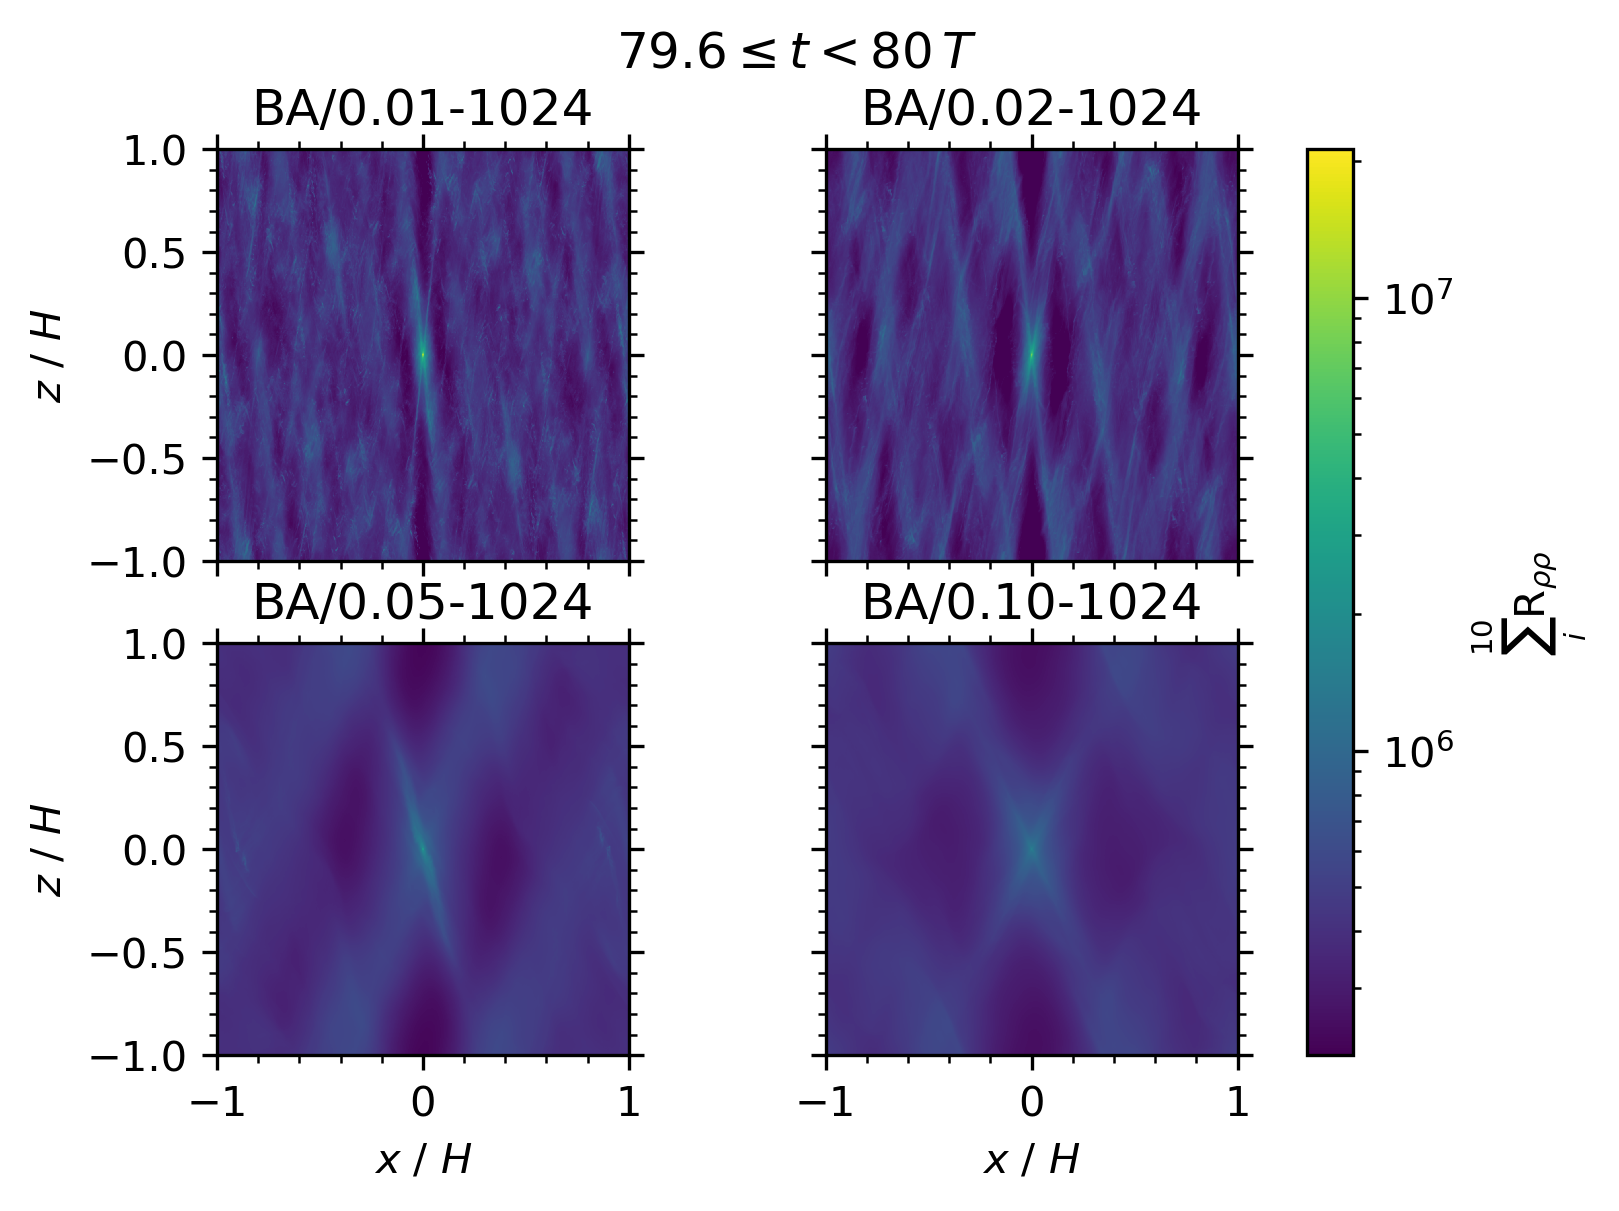

In [19]:
fig, axs = plt.subplots(2, 2, dpi=300)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
vmax, vmag = 0, 1e2
tmax, snum = 80, 10

for i,ax in enumerate(axs.flat):
    # Load snapshot and compute autocorrelation function
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    dt = athinput['output2']['dt']             # for rhop output
    omax = int(tmax/dt)                        # last athdf output
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%runs[i]\
                             +athinput["job"]["problem_id"]\
                             +f'.out2.{omax:05d}.athdf')
    xf, zf = data['x1f']/H, data['x2f']/H
    data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(runs[i], snum))
    stack = data['acs']
    if np.amax(stack) > vmax:
        vmax = np.amax(stack)
    clip = np.clip(stack, vmax/vmag, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
    ax.set(title='{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

# (+) Slopes

## $\Pi=0.01$

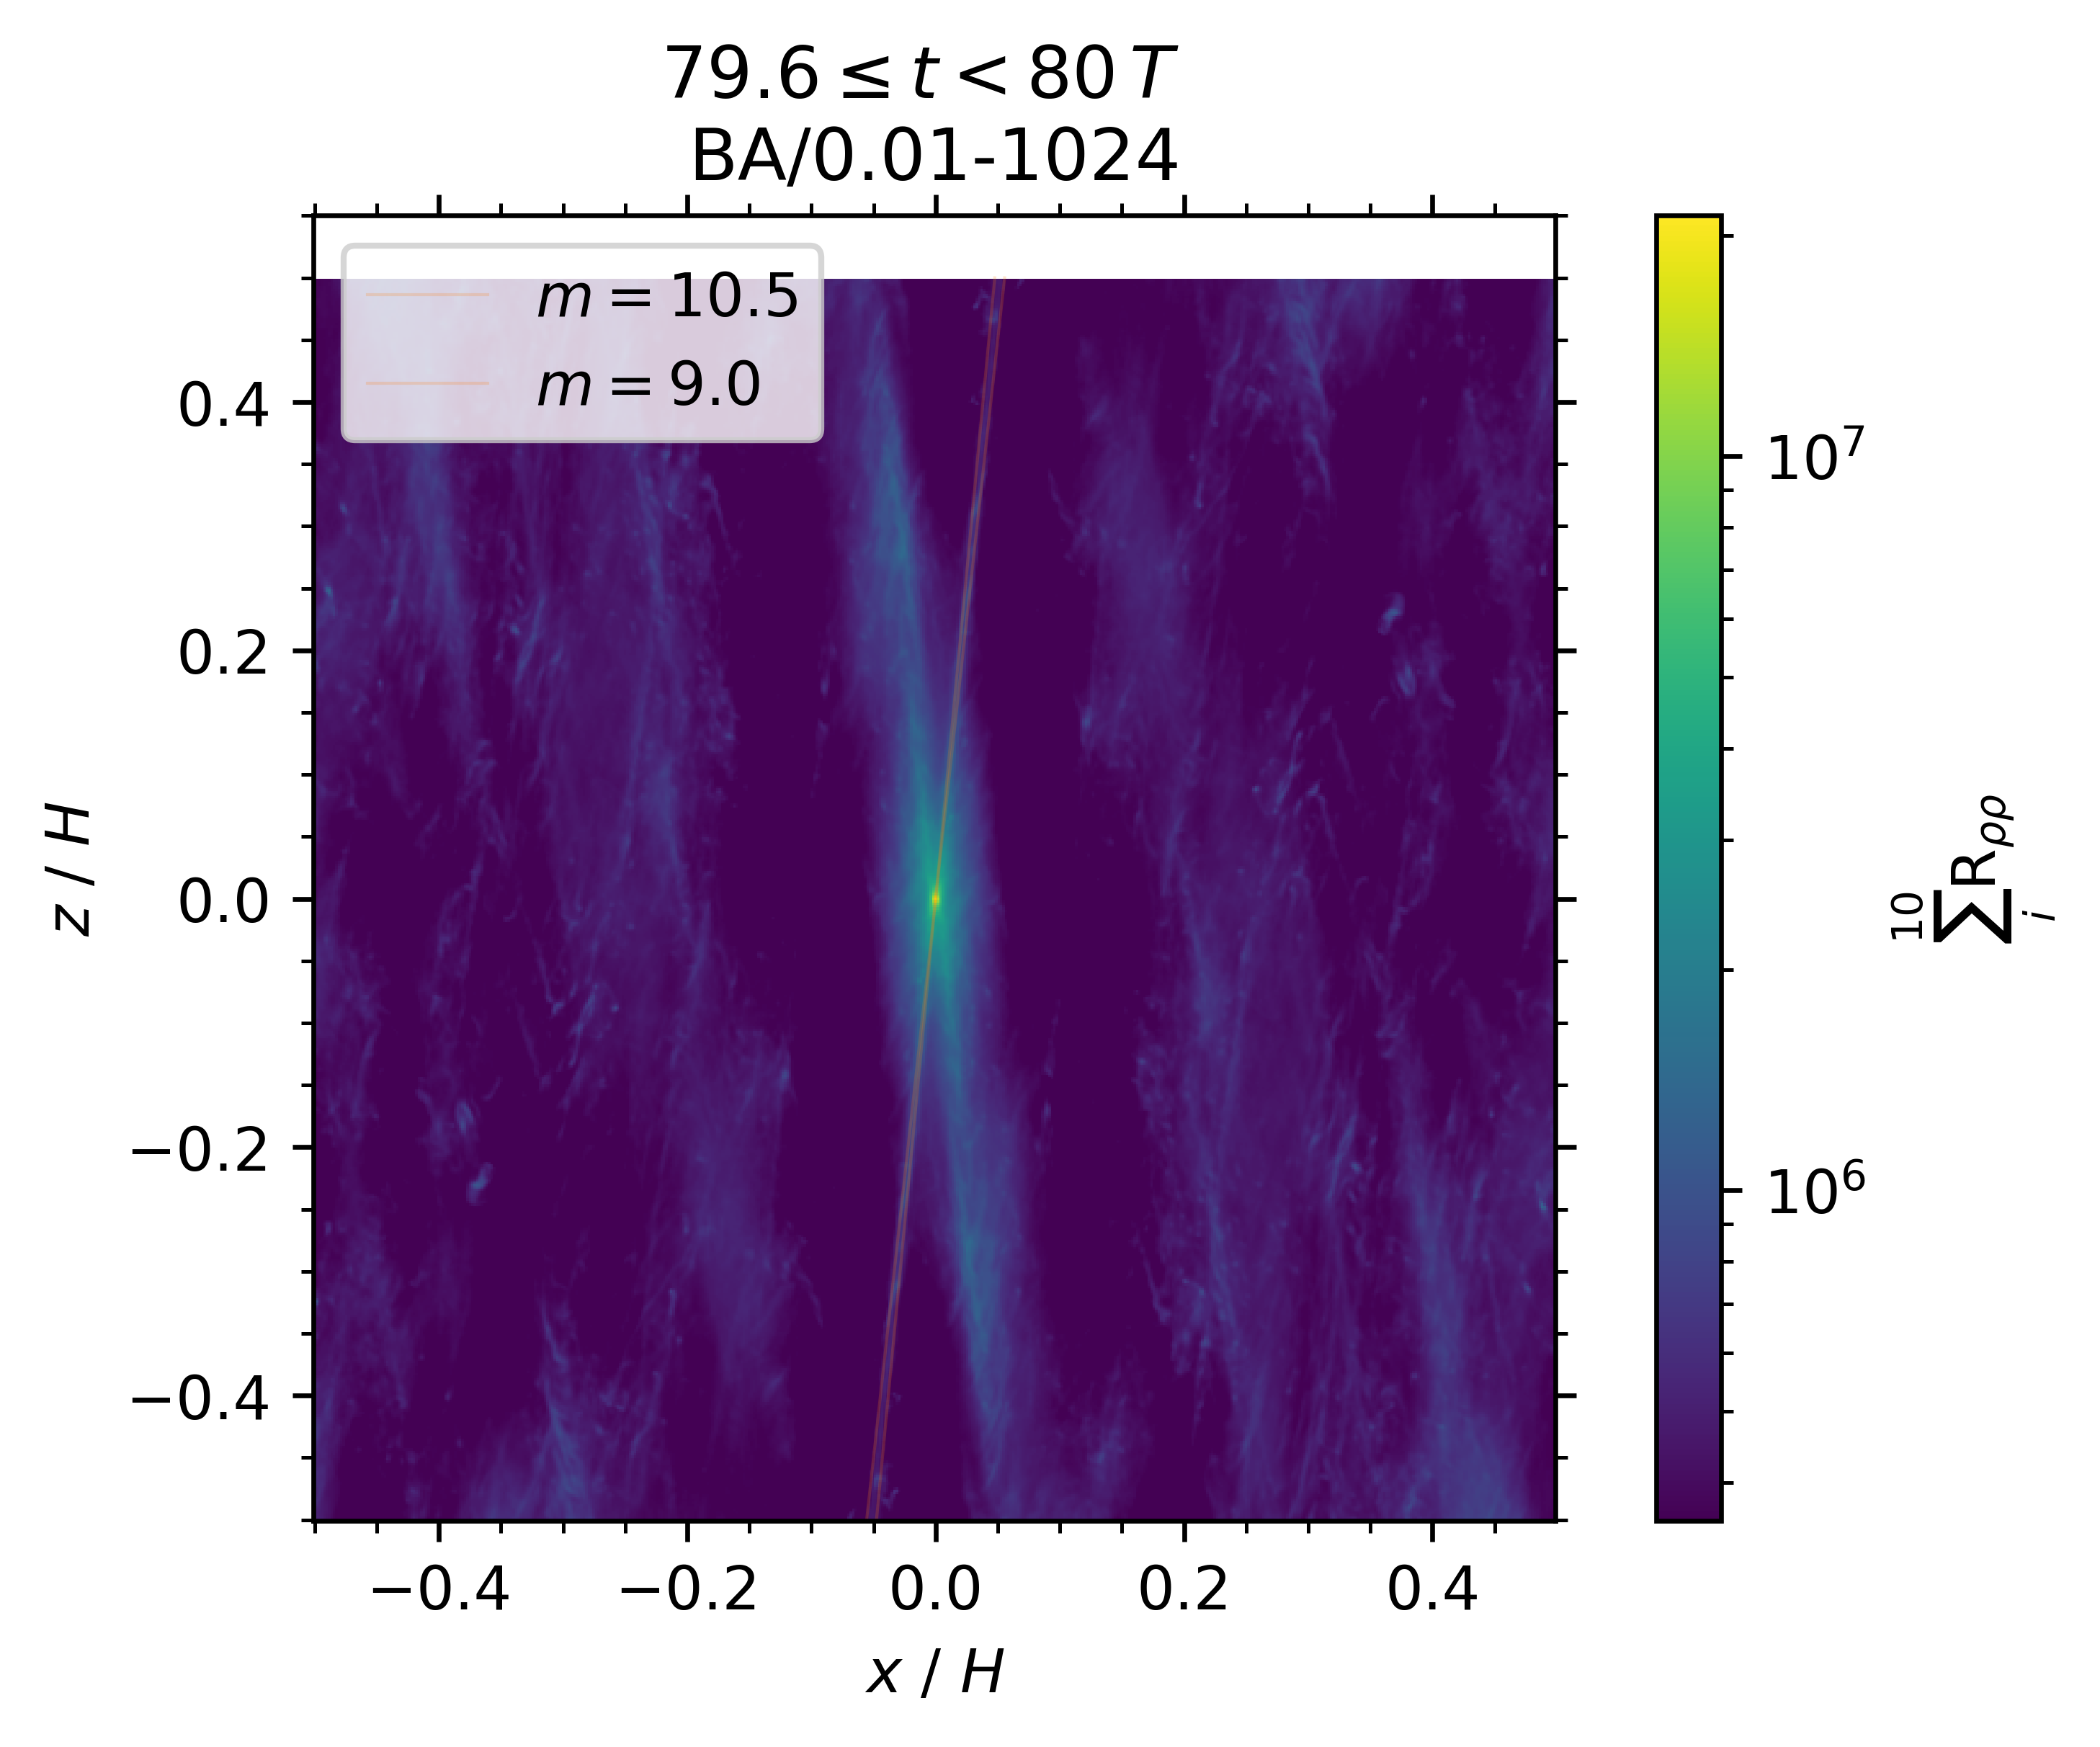

In [69]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.01-1024'
vmax, vmag = 0, 6e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [10.5, 9.0]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper left')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

## $\Pi=0.02$

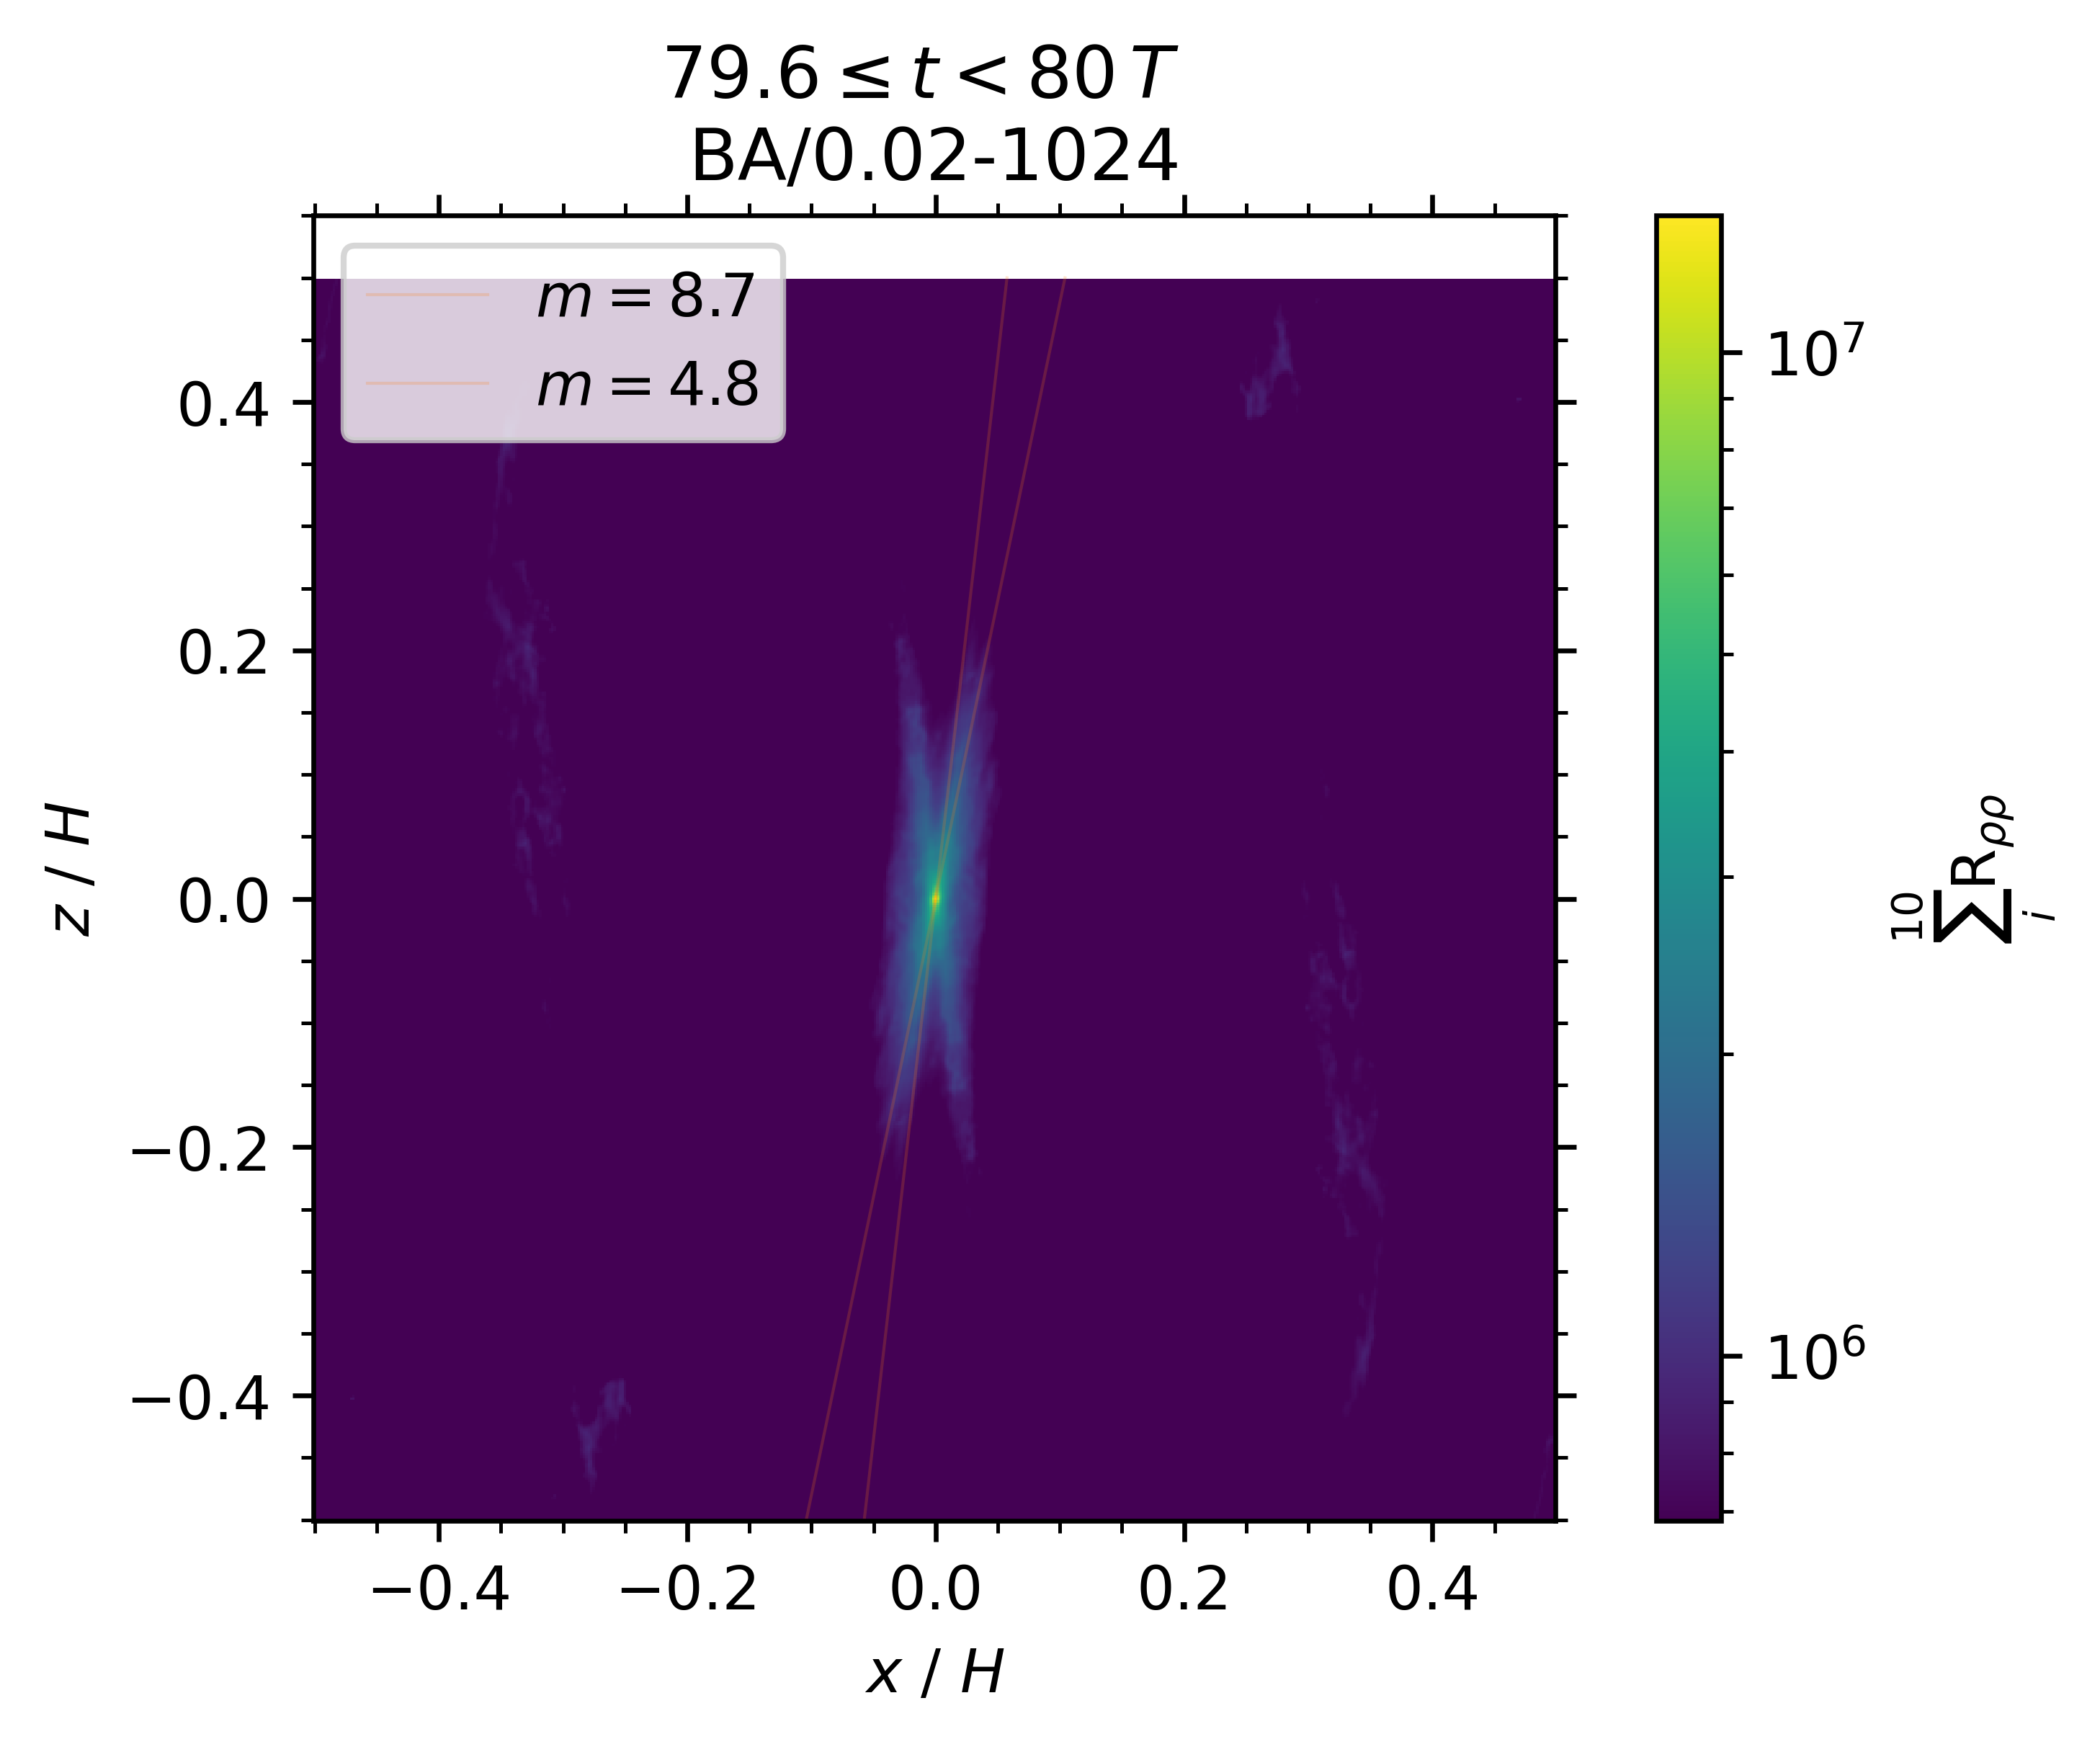

In [67]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.02-1024'
vmax, vmag = 0, 2e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [8.7, 4.8]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper left')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

## $\Pi=0.05$

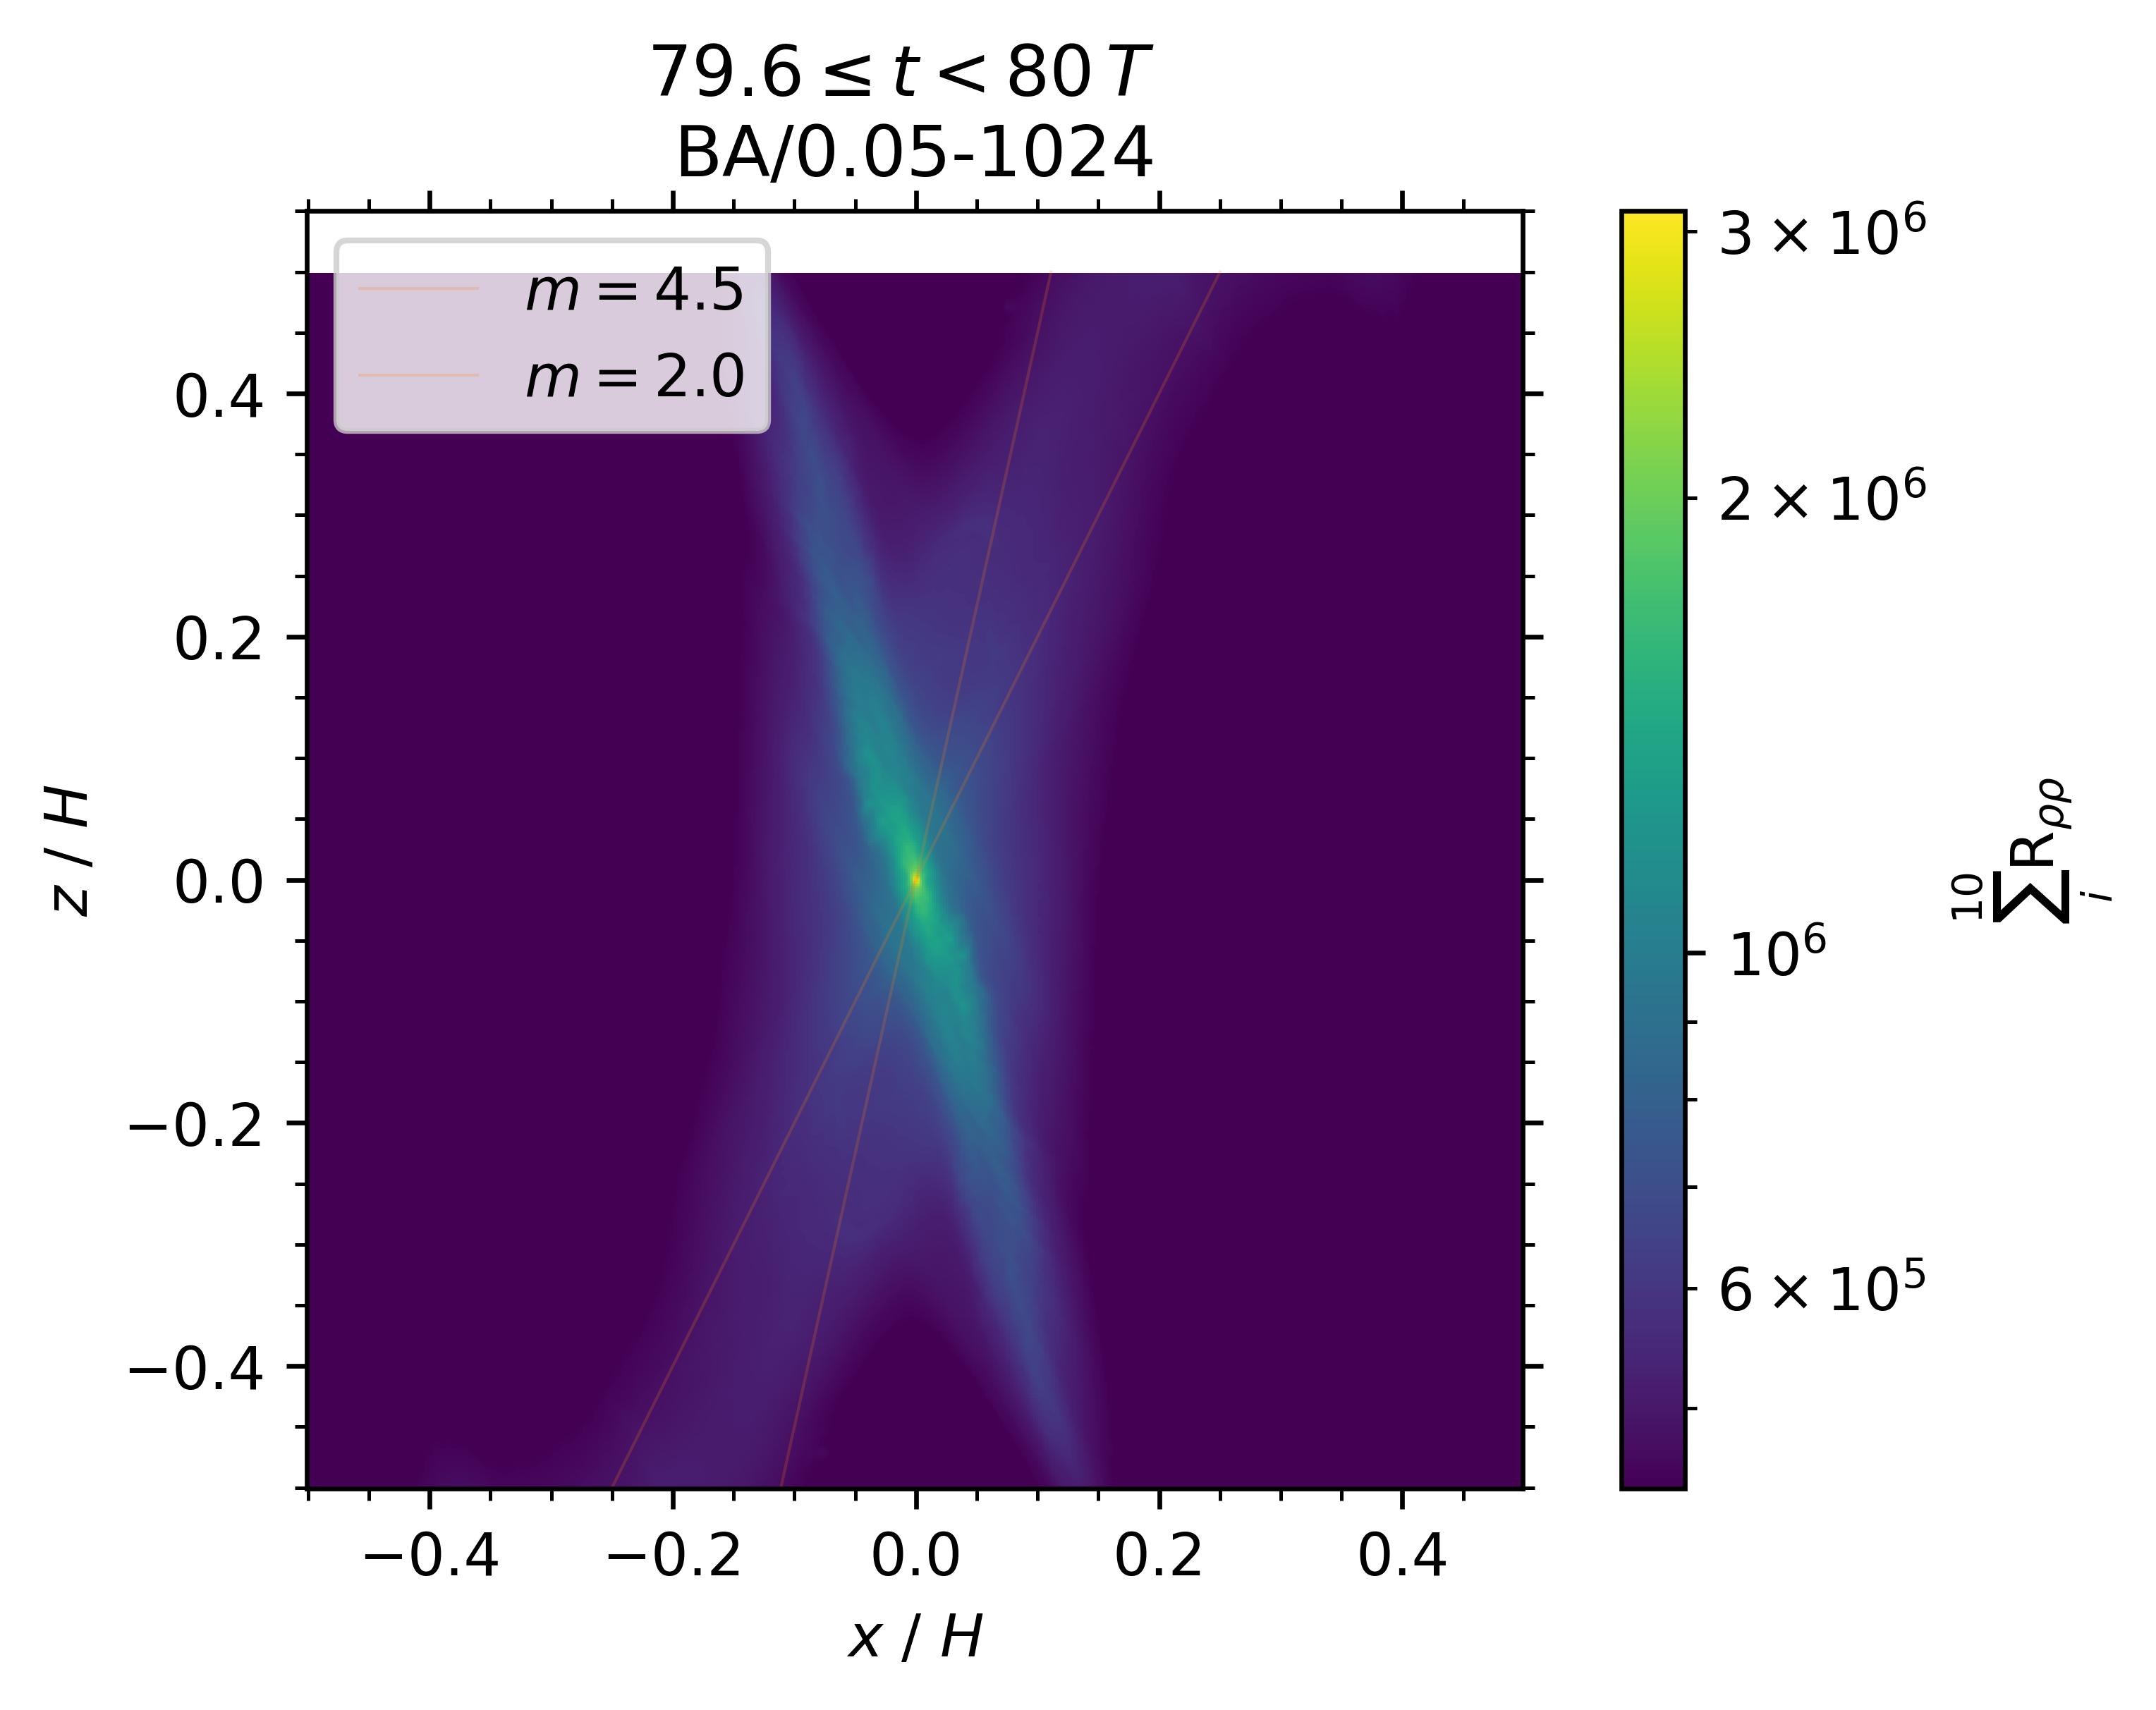

In [31]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.05-1024'
vmax, vmag = 0, 0.7e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [4.5, 2.0]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper left')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

## $\Pi=0.10$

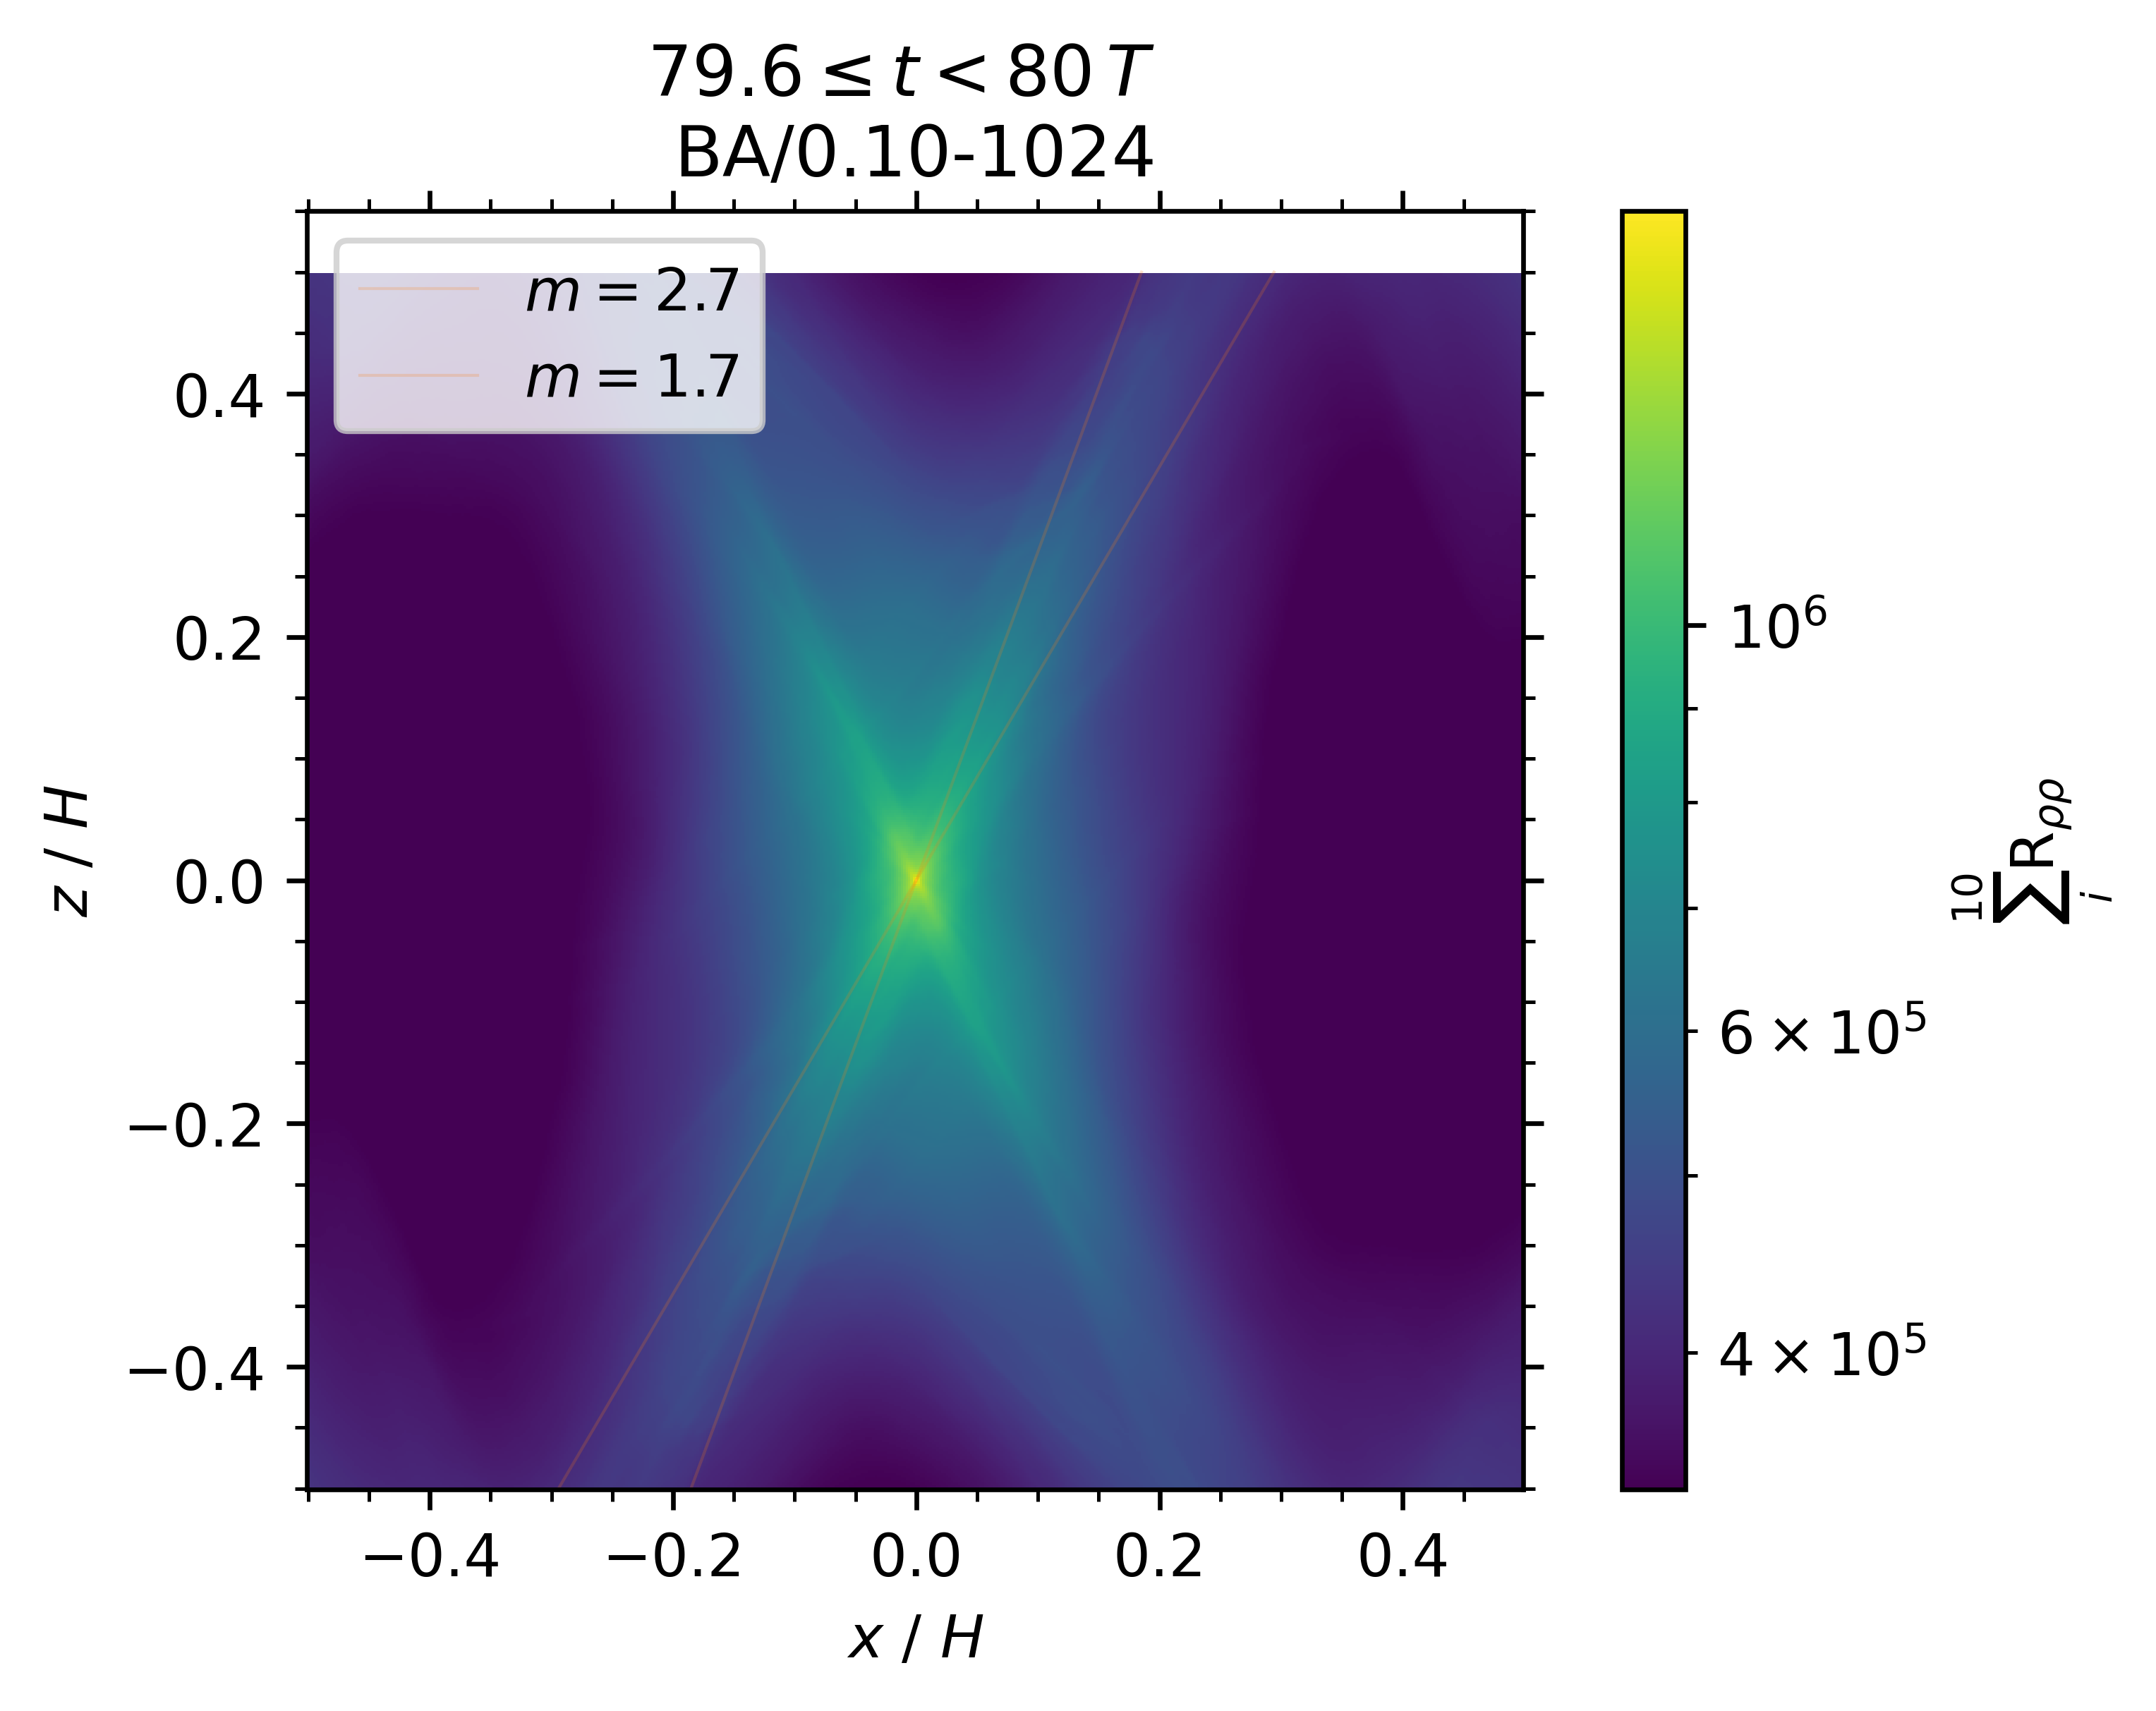

In [42]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.10-1024'
vmax, vmag = 0, 0.5e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [2.7, 1.7]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper left')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

# (-) Slopes

## $\Pi=0.01$

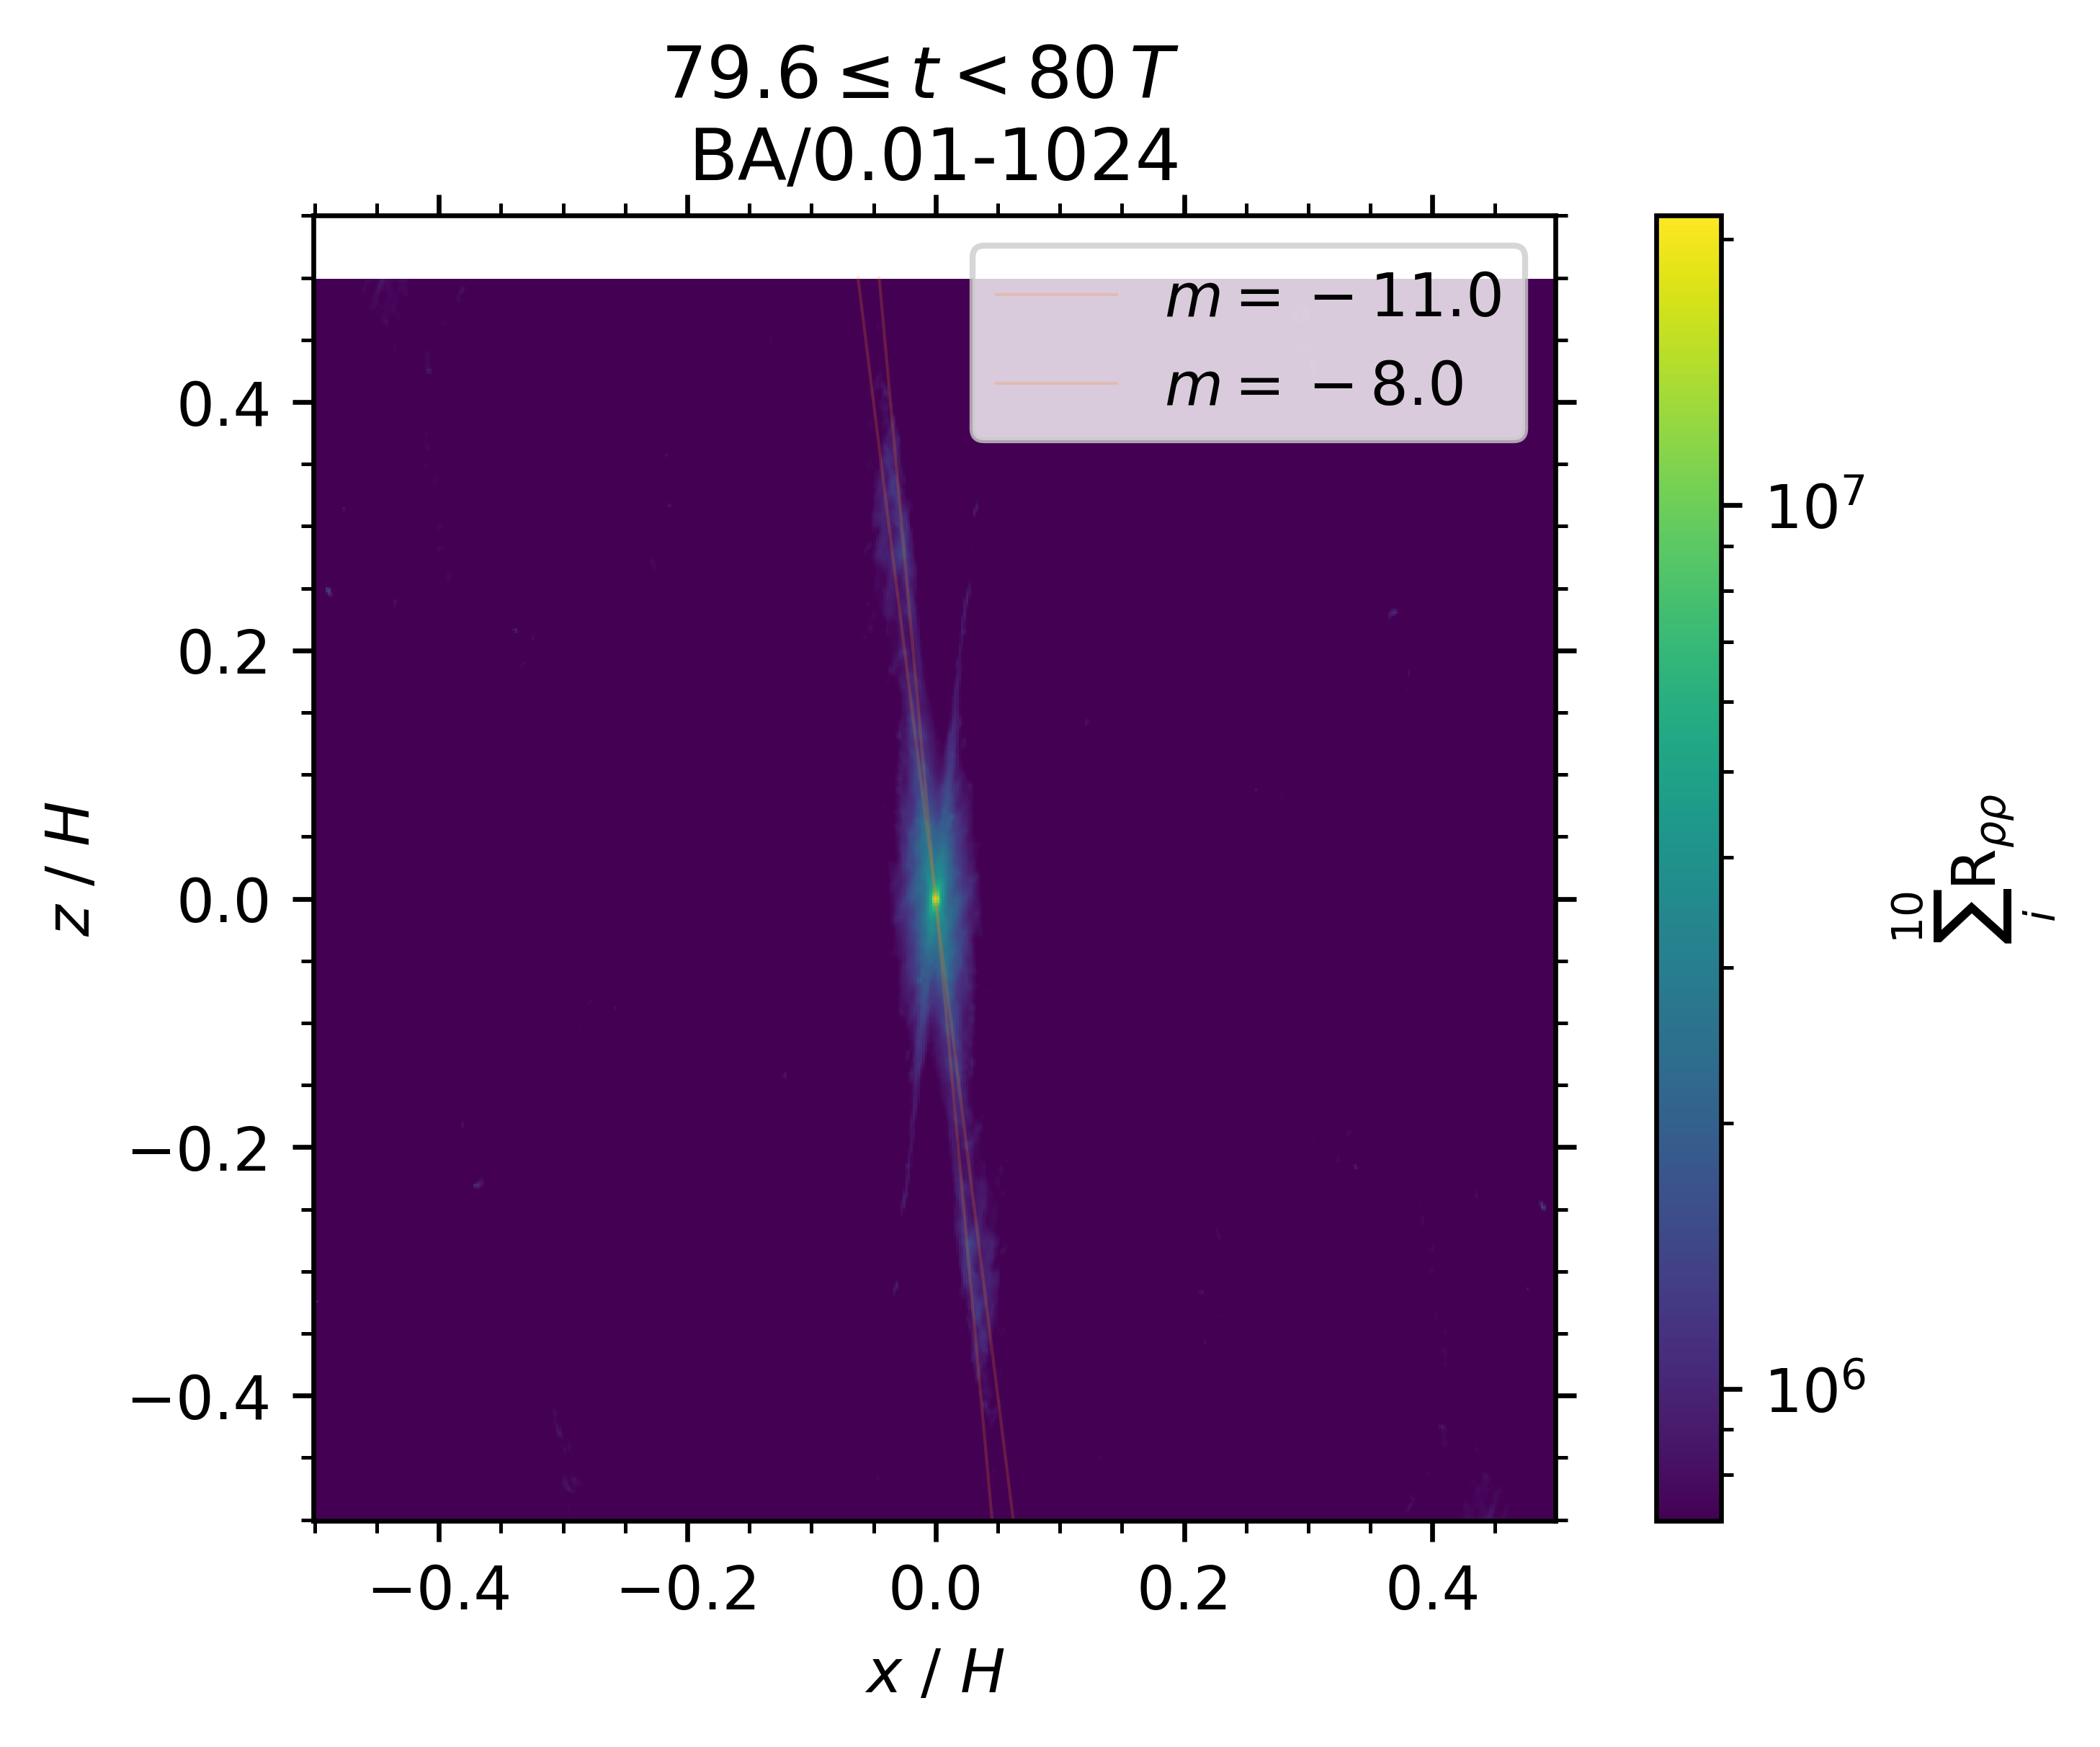

In [55]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.01-1024'
vmax, vmag = 0, 3e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [-11.0, -8]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper right')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

## $\Pi=0.02$

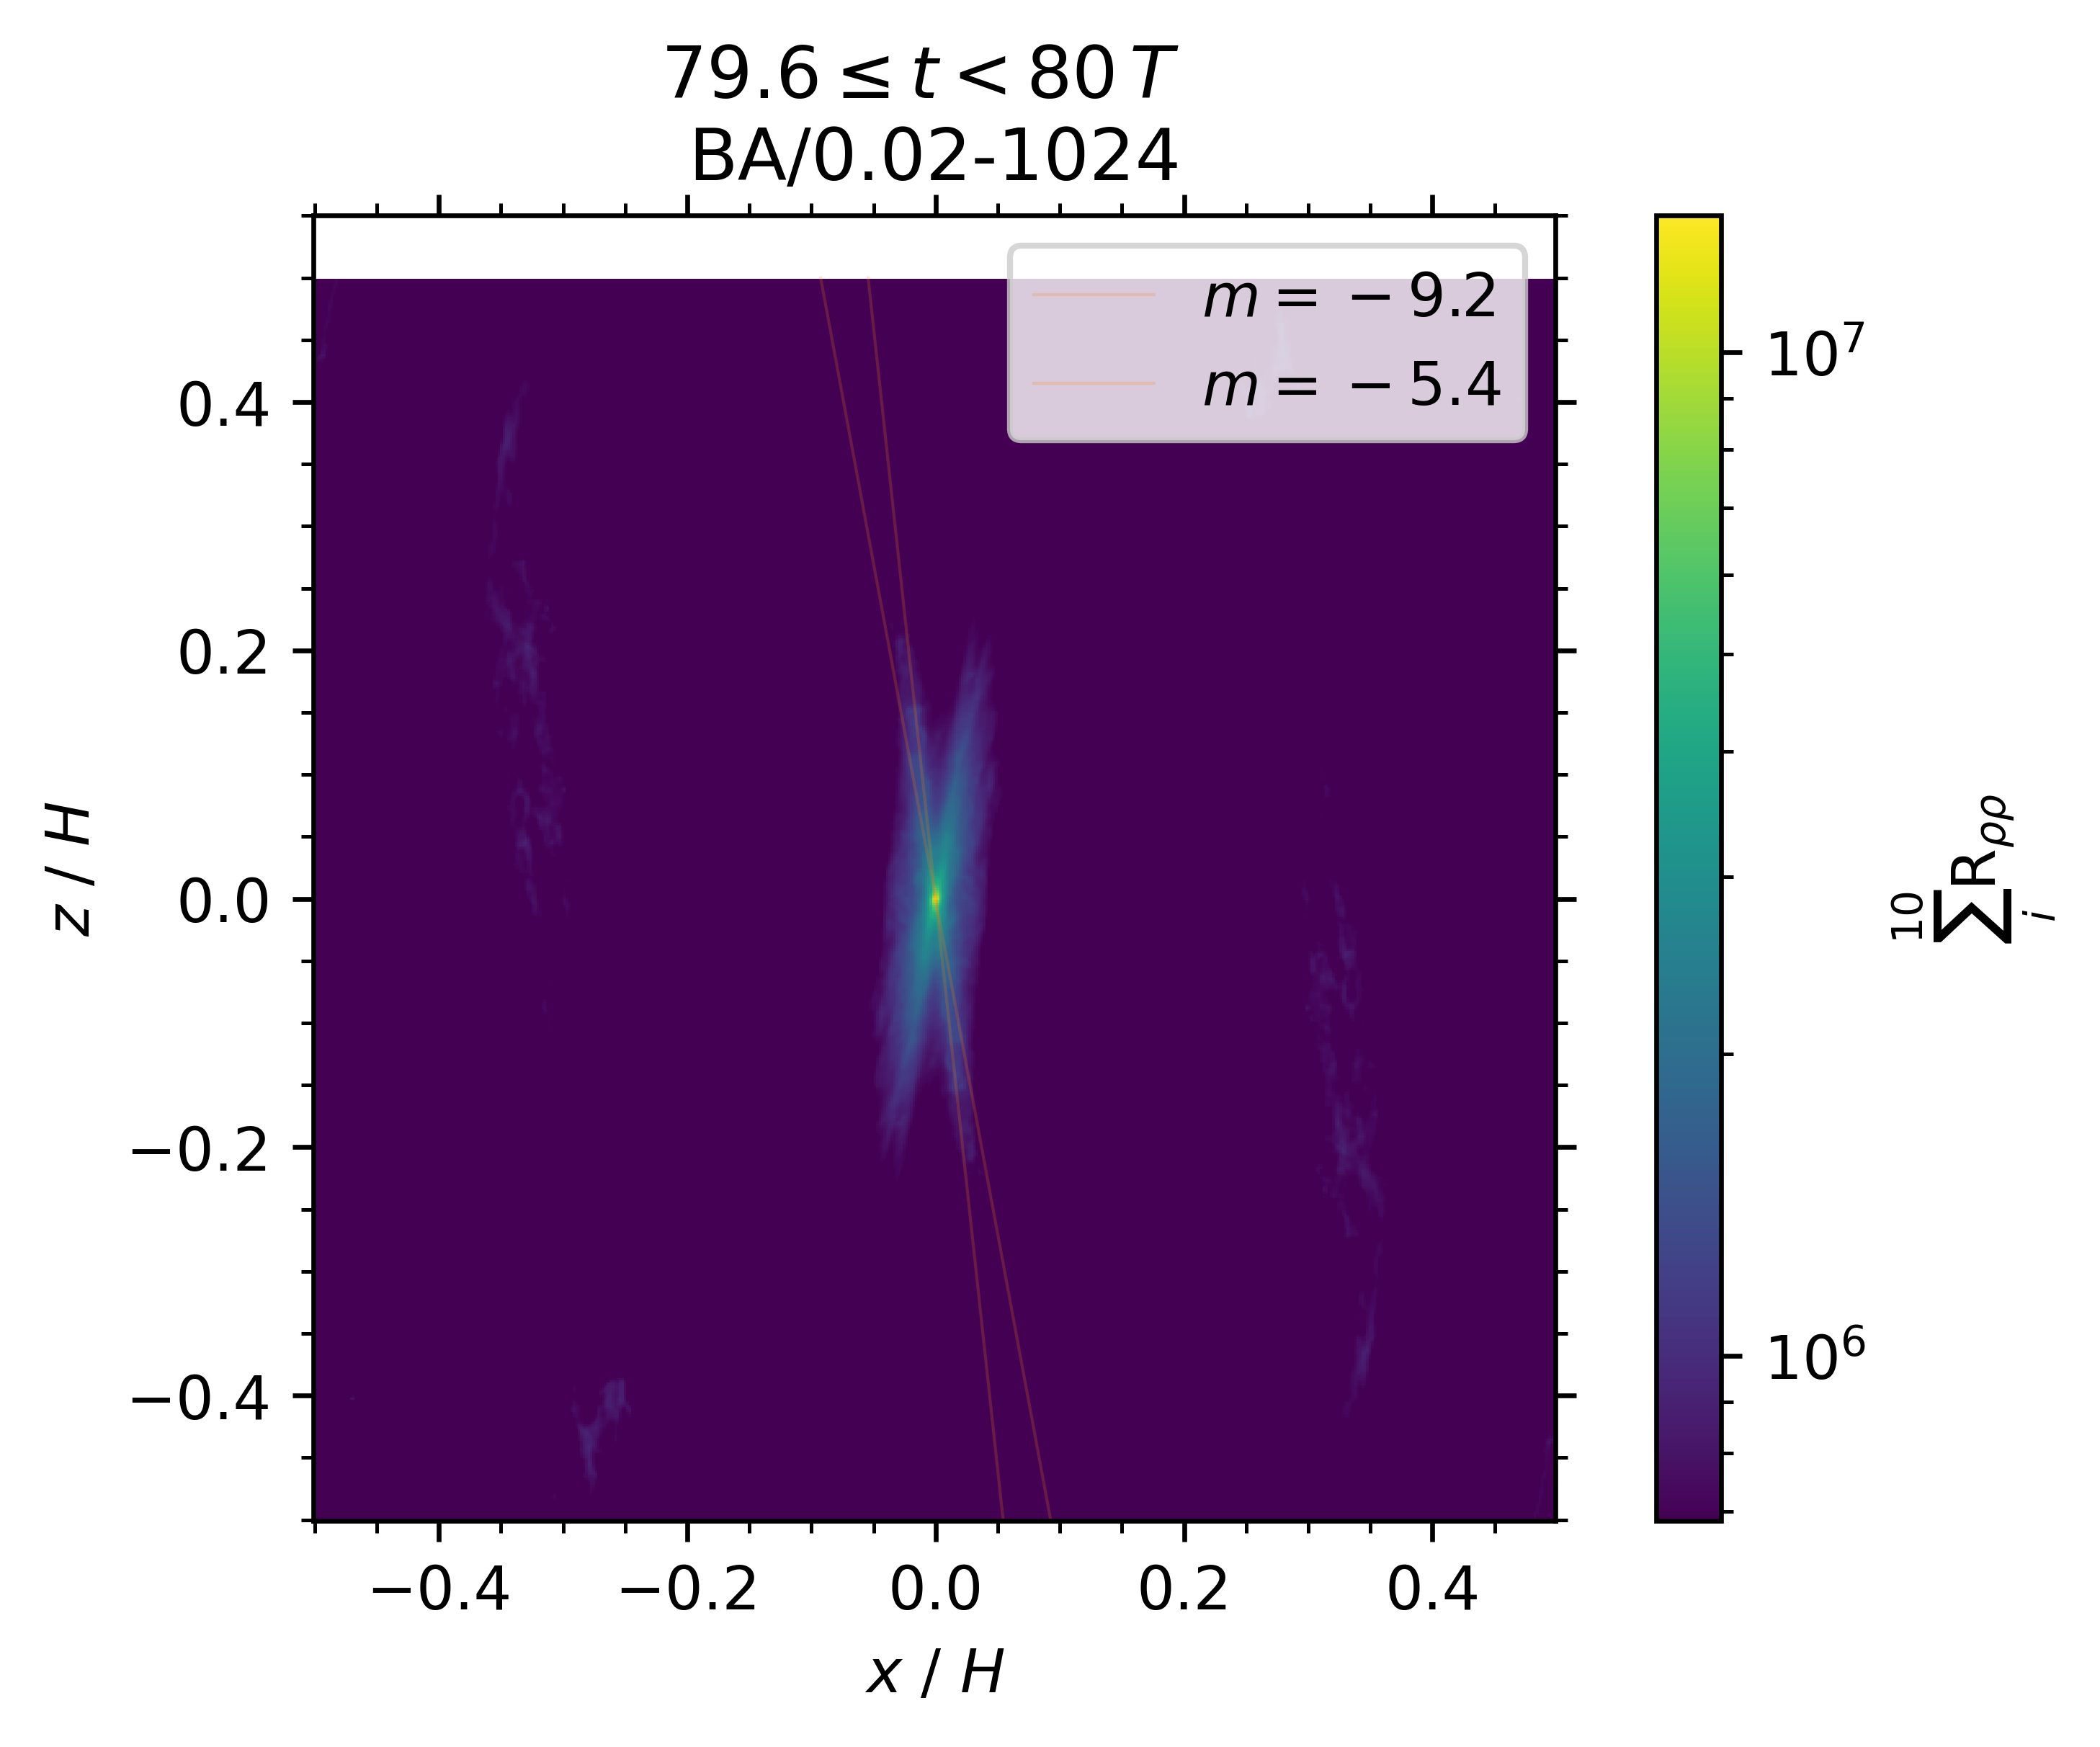

In [62]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.02-1024'
vmax, vmag = 0, 2e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [-9.2, -5.4]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper right')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

## $\Pi=0.05$

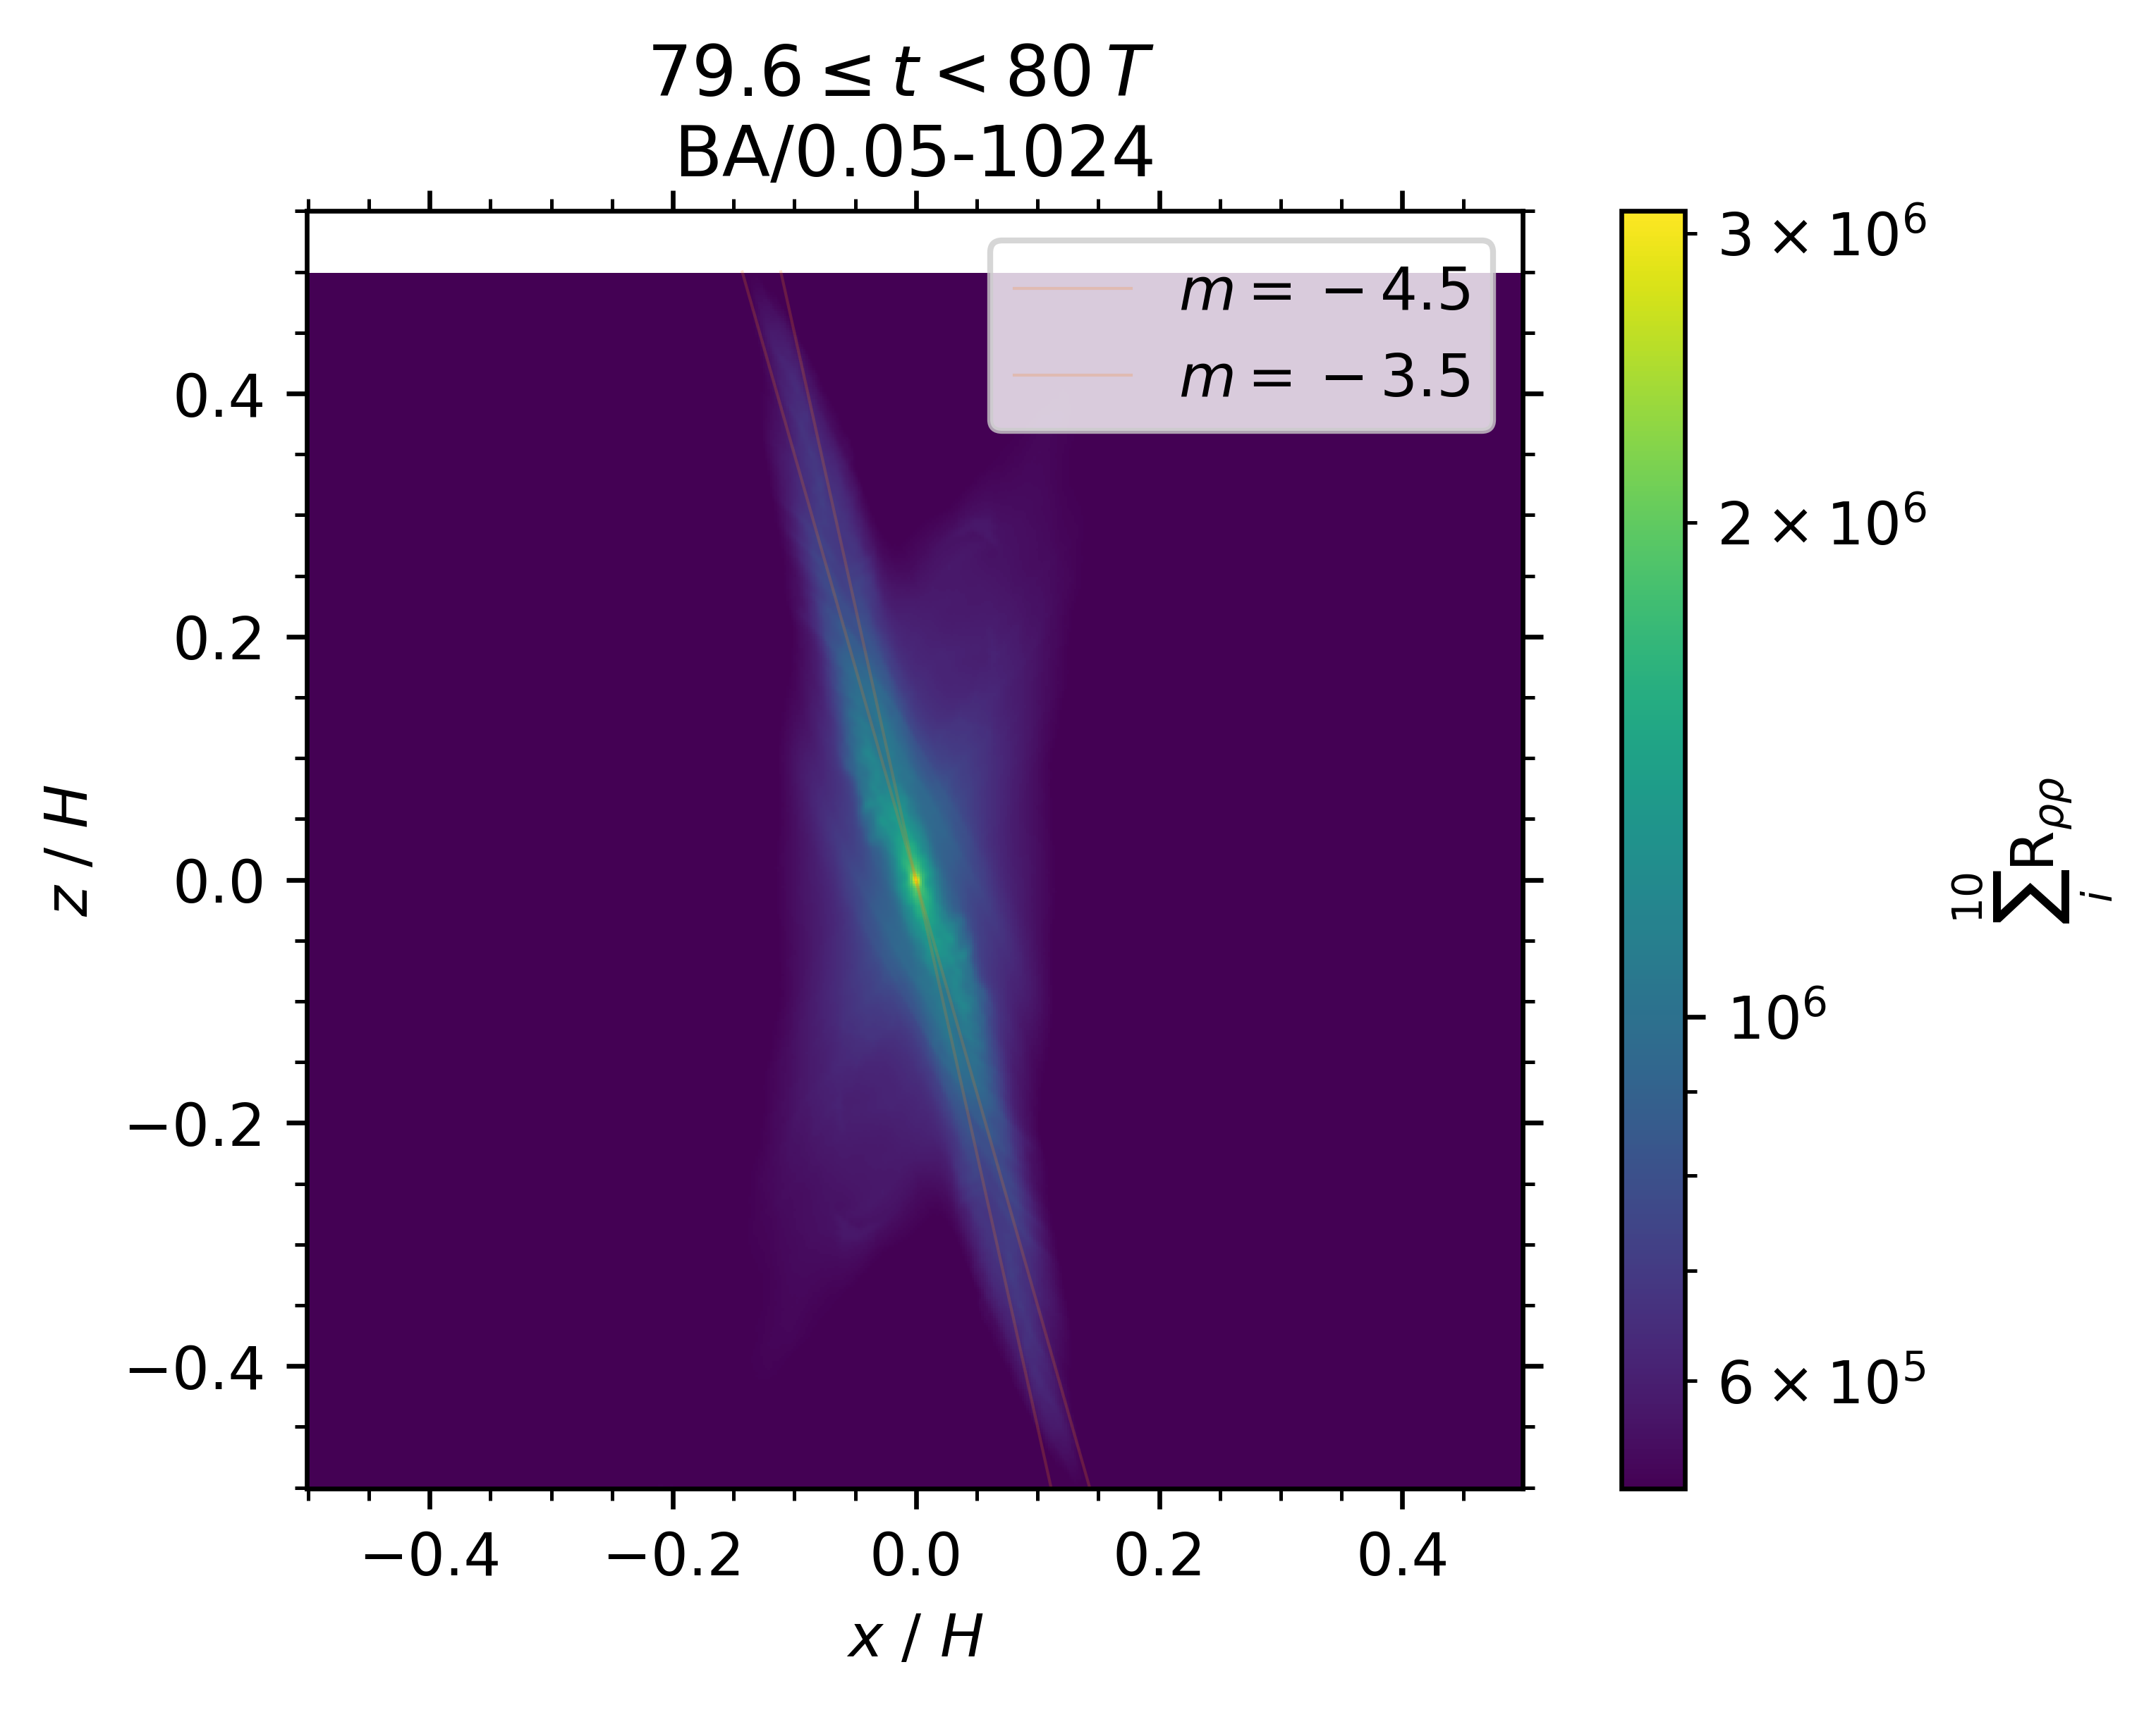

In [66]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.05-1024'
vmax, vmag = 0, 0.6e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [-4.5, -3.5]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper right')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

## $\Pi=0.10$

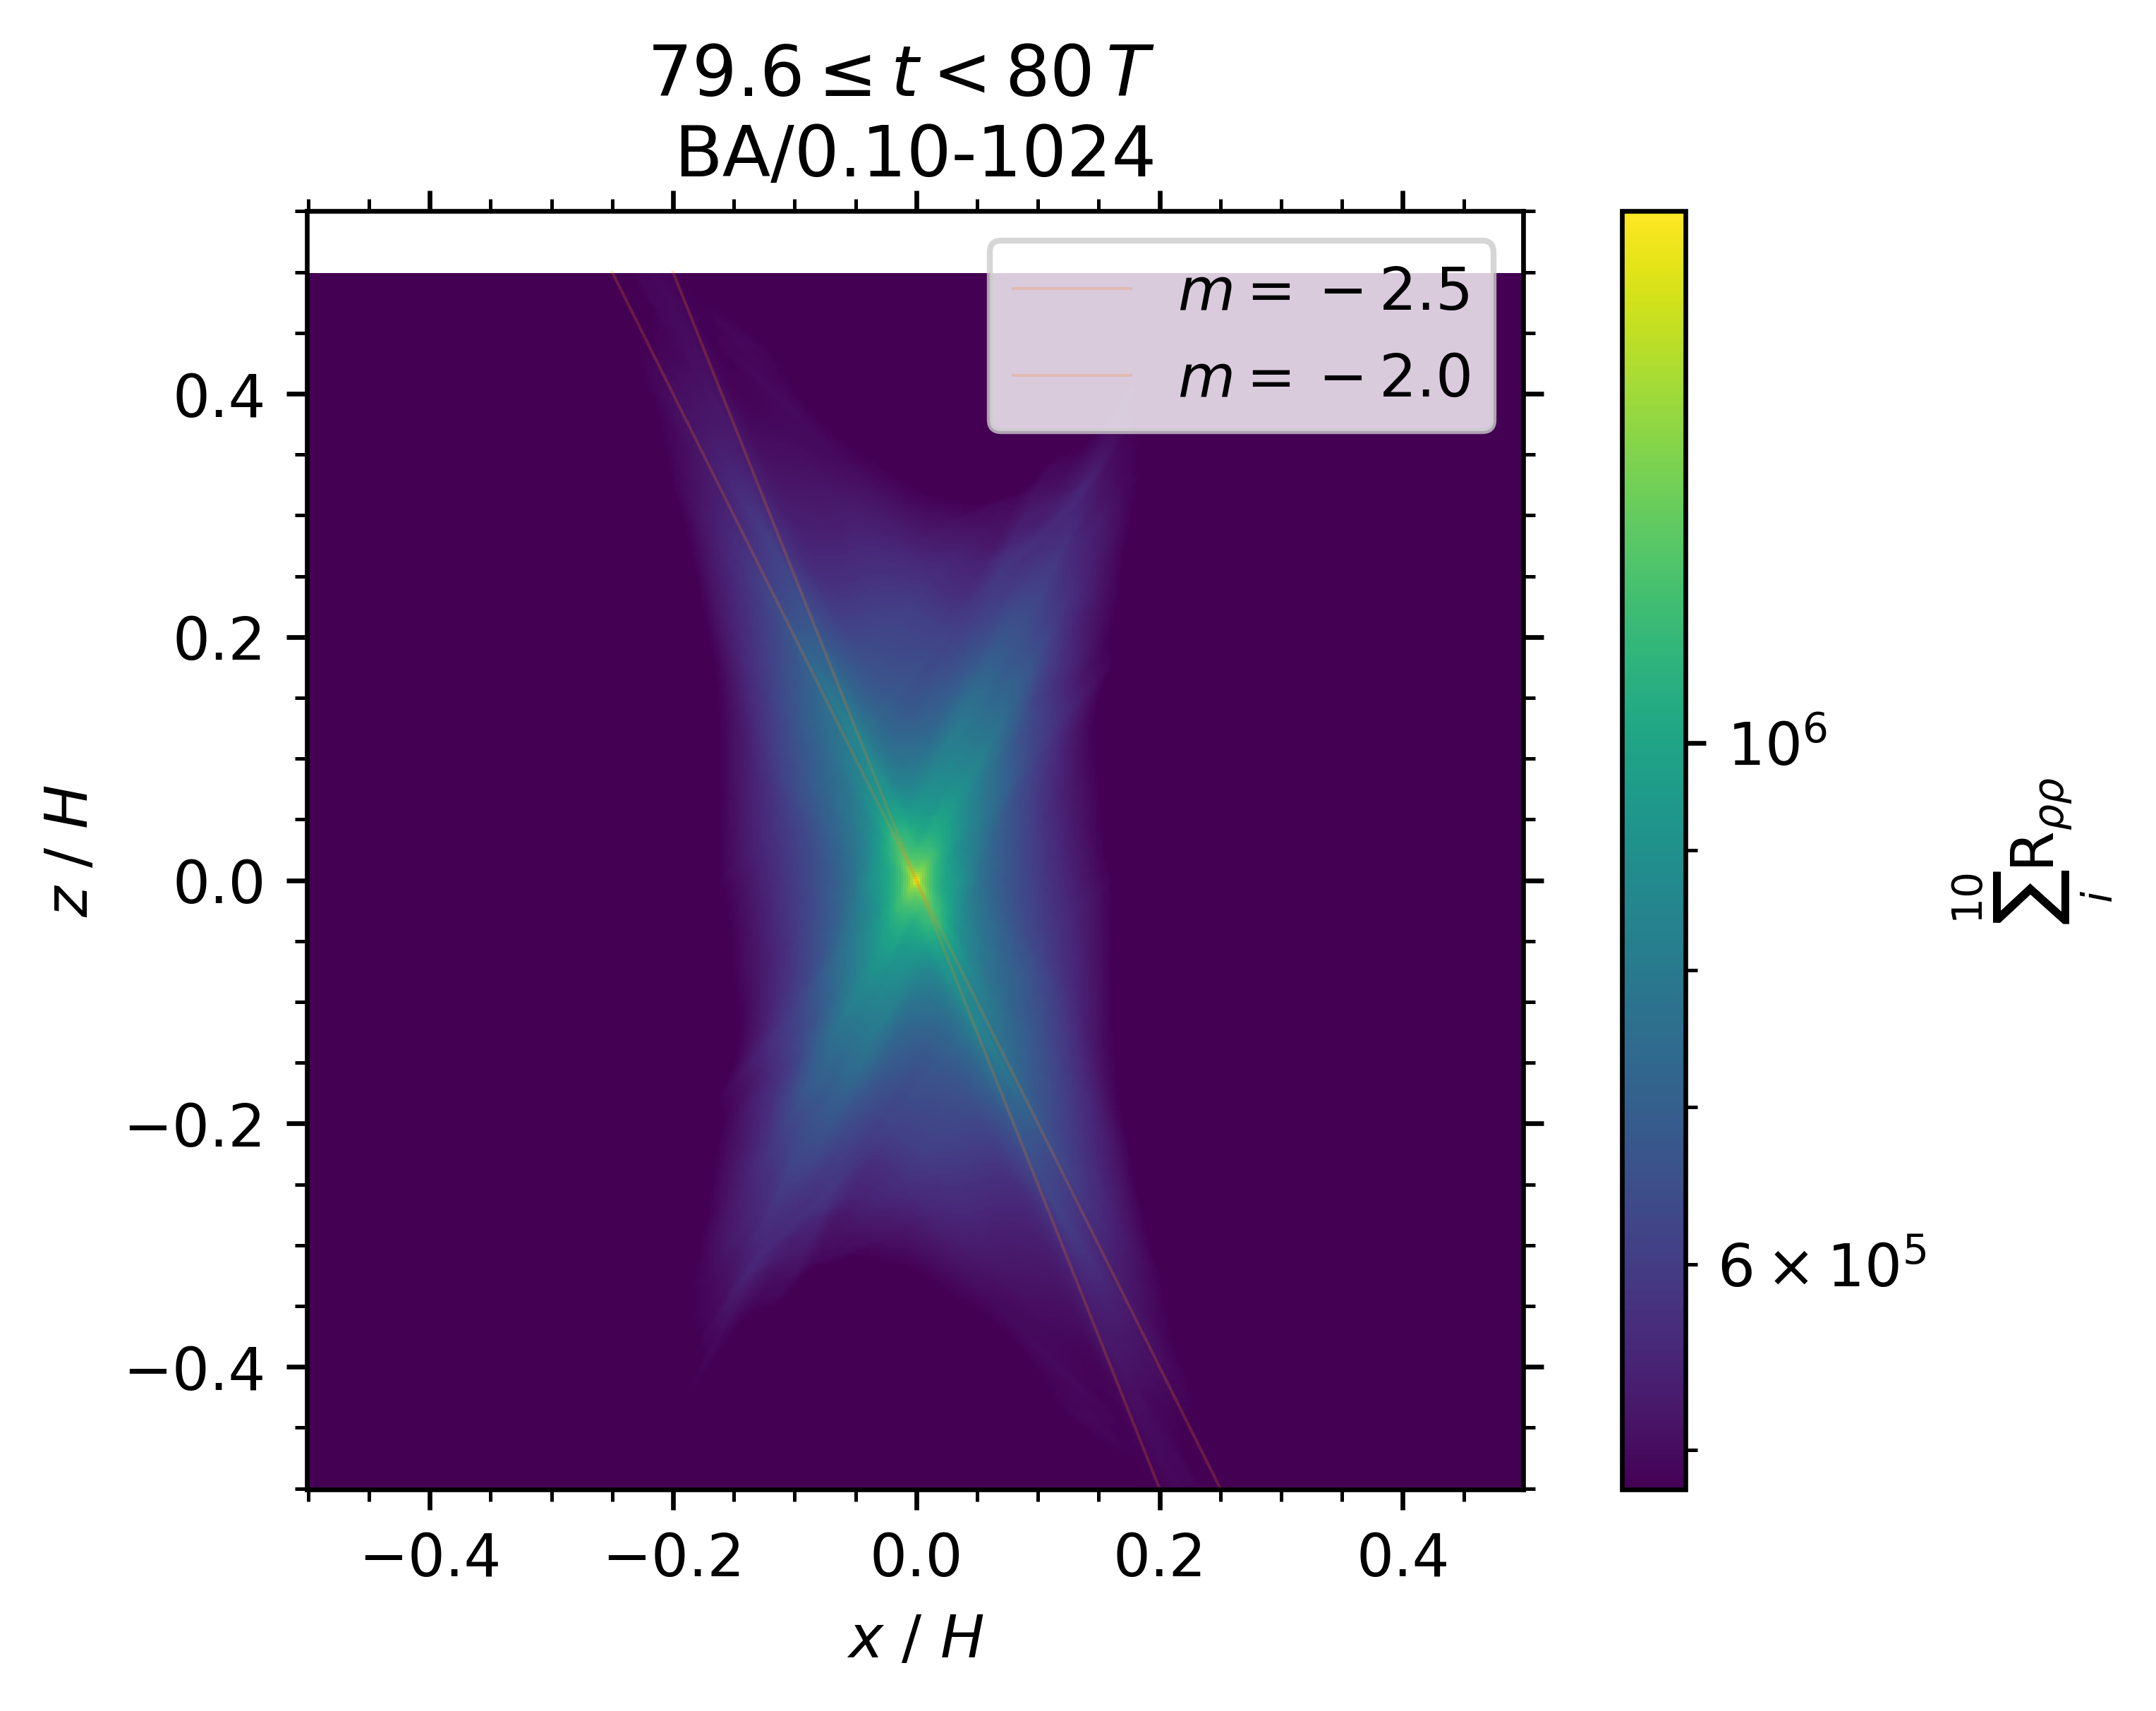

In [74]:
fig, ax = plt.subplots(dpi=600)
run = 'BA/0.10-1024'
vmax, vmag = 0, 0.35e1
tmax, snum = 80, 10
x = lambda y,m : y/m
y = np.asarray([-.5, .5])
ms = [-2.5, -2.0]

# Load snapshot and compute autocorrelation function
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
dt = athinput['output2']['dt']             # for rhop output
omax = int(tmax/dt)                        # last athdf output
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]\
                            +f'.out2.{omax:05d}.athdf')
xf, zf = data['x1f']/H, data['x2f']/H
data = np.load('../nonlinear/Pi/%s/output/acs-%d.npz'%(run, snum))
stack = data['acs']
if np.amax(stack) > vmax:
    vmax = np.amax(stack)
clip = np.clip(stack, vmax/vmag, vmax)

# Plot
img = ax.pcolormesh(xf[256:768], zf[256:768], clip[256:768,256:768],
                    norm=colors.LogNorm(vmax/vmag, vmax), shading='auto')
for m in ms:
    ax.plot(x(y,m), y, color='tab:orange', lw=0.5, label=f'$m={m:.1f}$', alpha=0.2)
ax.set(title=f'{run:s}', aspect='equal',
        xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
ax.label_outer()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.legend(loc='upper right')
fig.suptitle(f'${(tmax*(1-snum/omax)):.1f}\leq t<{tmax:.0f}\,T$')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\sum_i^{10}\mathrm{R}_{\rho\rho}$')

# Power-law Fit

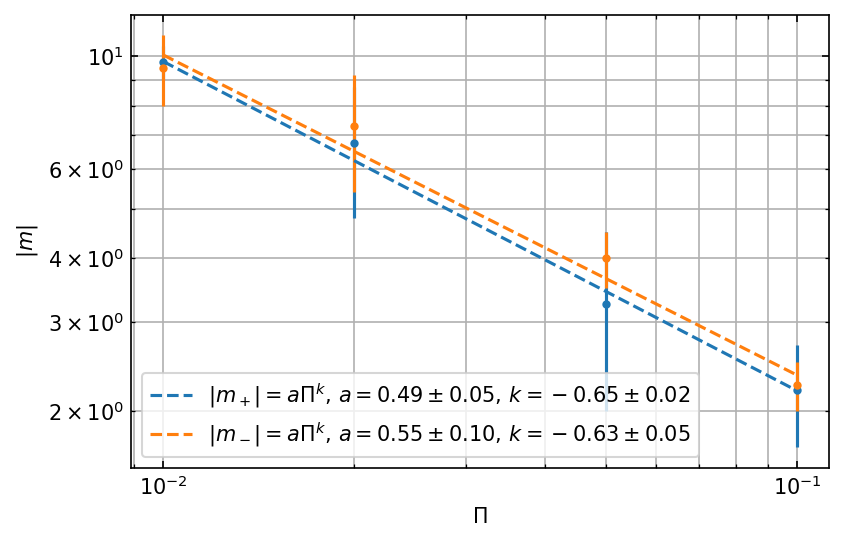

In [155]:
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Pis = np.zeros(len(runs))
rpss = np.asarray([[10.5, 9.0],
                   [8.7, 4.8],
                   [4.5, 2.0],
                   [2.7, 1.7]]) # raw positive slopes
rnss = np.asarray([[-11.0, -8.0],
                   [-9.2, -5.4],
                   [-4.5, -3.5],
                   [-2.5, -2.0]]) # raw negative slopes
μpss, μnss = np.mean(rpss, axis=1), np.mean(rnss, axis=1)
σpss = (np.abs(np.diff(rpss, 1))/2).flatten()
σnss = (np.abs(np.diff(rnss, 1))/2).flatten()

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    Pis[i] = athinput['problem']['duy0']  # global rad. press. grad.

func = lambda x, a, k : a*x**k # power-law model function
ppopt, ppcov = curve_fit(func, Pis, μpss, sigma=σpss)
npopt, npcov = curve_fit(func, Pis, np.abs(μnss), sigma=σnss)
pperr, nperr = np.sqrt(np.diag(ppcov)), np.sqrt(np.diag(npcov))
plabel = r'$|m_+|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        ppopt[0], pperr[0], ppopt[1], pperr[1])
nlabel = r'$|m_-|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        npopt[0], nperr[0], npopt[1], nperr[1])

fig, ax = plt.subplots(dpi=150)
ax.errorbar(Pis, μpss, σpss, fmt='.')
ax.errorbar(Pis, np.abs(μnss), σnss, fmt='.')
ax.plot(Pis, func(Pis, *ppopt), ls='--', color='tab:blue', label=plabel)
ax.plot(Pis, func(Pis, *npopt), ls='--', color='tab:orange', label=nlabel)
ax.set(xlabel=r'$\Pi$', ylabel=r'$|m|$', xscale='log', yscale='log')
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '⟨𝑚₊⟩': μpss,
    '𝜎_𝑚₊': σpss,
    '⟨𝑚₋⟩': μnss,
    '𝜎_𝑚₋': σnss})
df.style.format({
    '⟨𝑚₊⟩': '{:.1f}',
    '𝜎_𝑚₊': '{:.2f}',
    '⟨𝑚₋⟩': '{:.1f}',
    '𝜎_𝑚₋': '{:.2f}',})